# Libraries

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import norm, skew

# Loading data

In [5]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [6]:
df = pd.concat([train,test])

In [7]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500.0
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500.0
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000.0
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

# EDA 

Checking the skewness of data

In [9]:
#skewness and kurtosis
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


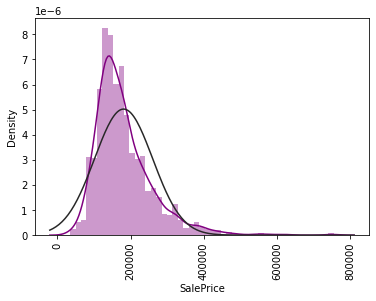

In [10]:
sns.distplot(train['SalePrice'], color= 'purple',fit=norm);
plt.xticks(rotation=90);
plt.show()

The data is right-skewed which may affect our model.
More info: https://towardsdatascience.com/skewed-data-a-problem-to-your-statistical-model-9a6b5bb74e37

Making log transformation to achieve normal distribution

In [11]:
train.SalePrice = np.log(train.SalePrice)
df.SalePrice = np.log(df.SalePrice)

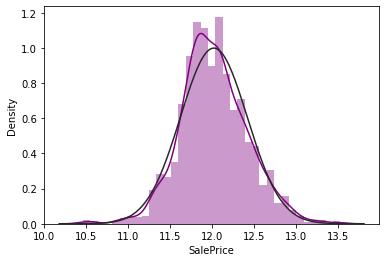

Skewness: 0.121335
Kurtosis: 0.809532


In [12]:
sns.distplot(train['SalePrice'], color= 'purple', fit=norm);
plt.show()
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

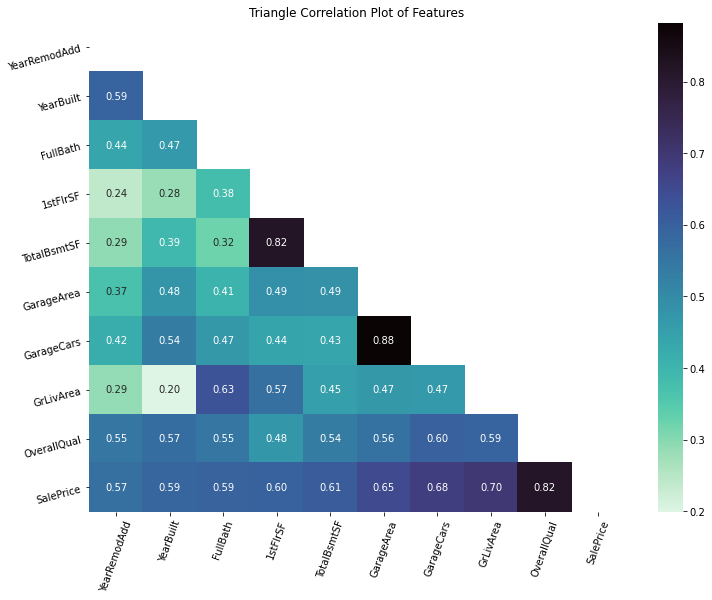

In [13]:
#saleprice correlation matrix

cols = train.corr().nlargest(10, 'SalePrice')['SalePrice'].index
cols = np.array(list(reversed(cols)))
cm = train[cols].corr()
mask = np.triu(np.ones_like(cm, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 9))
g1 = sns.heatmap(cm,cmap='mako_r',fmt='.2f', annot=True, mask=mask)
g1.set_xticklabels(g1.get_xticklabels(),rotation=70,fontsize=10)
g1.set_yticklabels(g1.get_yticklabels(),rotation=15,fontsize=10)
plt.title("Triangle Correlation Plot of Features")
plt.show()

Conclusions:
1. All of those features have influence on Sale Price
2. Pairs: GrLivArea and TotRmsAbvGrd, TotalBsmtSF and 1stFlrSF, GarageCars and GarageArea are higly correlated with each other
3. Heatmap does not include categorical data which we will look after in next steps

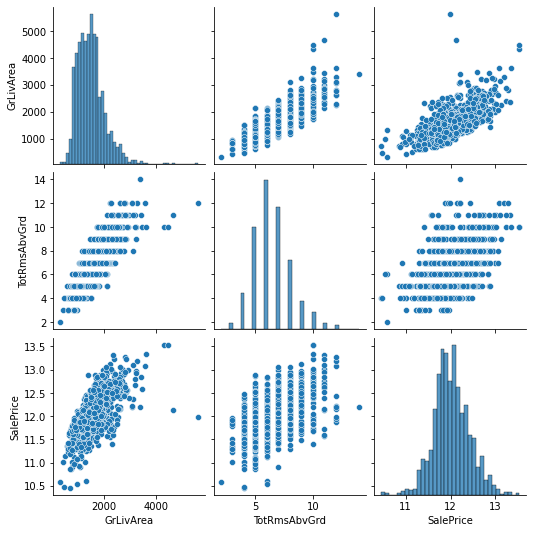

In [14]:
sns.pairplot(train[["GrLivArea","TotRmsAbvGrd","SalePrice"]])
plt.show()

GrLivArea seems to be explain slightly better than TotRmsAbvGrd that is why we will consider reducing number of features by dropping TotRmsAbvGrd.

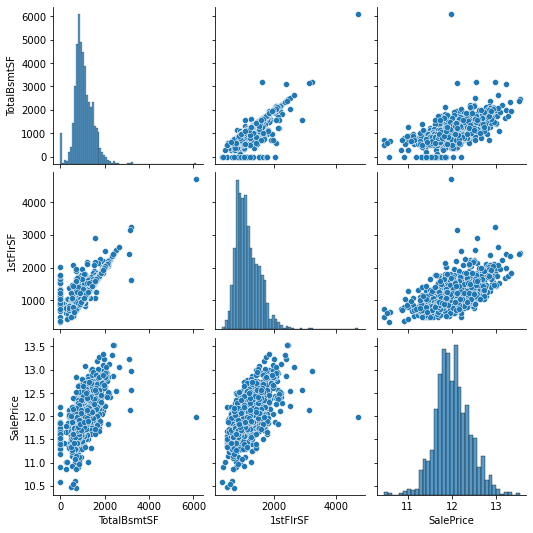

In [15]:
sns.pairplot(train[["TotalBsmtSF","1stFlrSF","SalePrice"]])
plt.show()

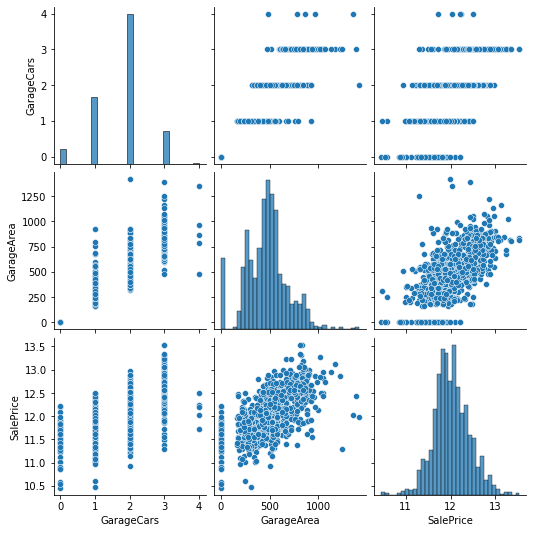

In [16]:
sns.pairplot(train[["GarageCars","GarageArea","SalePrice"]])
plt.show()

Similarly to situation with GrLivArea, the GarageArea feature will be excluded.

# Feature Engineering

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

# List of features containing NA's

1. MSZoning, 
2. LotFrontage, 
3. Alley (more than 2000), 
4. Utilities, 
5. Exterior1st, 
6. Exterior2nd, 
7. MasVnrType, 
8. MasVnrArea, 
9. BsmtQual, 
10. BsmtCond, 
11. BsmtExposure, 
12. BsmtFinType1, 
13. BsmtFinSF1, 
14. BsmtFinType2, 
15. BsmtFinSF2, 
16. BsmtUnfSF, 
17. TotalBsmtSF, 
18. Electrical, 
19. BsmtFullBath, 
20. BsmtHalfBath, 
21. KitchenQual, 
22. Functional, 
23. FireplaceQu (more than 1000), 
24. GarageType,
25. GarageYrBlt,
26. GarageFinish,
27. GarageCars,
28. GarageArea,
29. GarageQual,
30. GarageCond,
31. PoolQC(more than 2000), 
32. Fence(more than 2000), 
33. MiscFeature (more than 2000), 
34. SaleType

# Handling with NA's

In [18]:
df.MSZoning[df.MSZoning.isna() == True] = random.choice(['A','C','FV','I','RH','RL','RP','RM'])

In [19]:
df.LotFrontage[df.LotFrontage.isna() == True] = df.LotFrontage.median()

In [20]:
df.Alley[df.Alley.isna()==True] = 'None'

In [21]:
df.Utilities[df.Utilities.isna() == True] = random.choice(['AllPub','NoSewr','NoSeWa','ELO'])

In [22]:
df.Exterior1st[df.Exterior1st.isna()==True] = random.choice(['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc',
                                                'MetalSd','Other','Plywodd','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'])
df.Exterior2nd[df.Exterior2nd.isna()==True] = random.choice(['AsbShng','AsphShn','BrkComm','BrkFace','CBlock','CemntBd','HdBoard','ImStucc',
                                                'MetalSd','Other','Plywodd','PreCast','Stone','Stucco','VinylSd','Wd Sdng','WdShing'])


In [23]:
df.MasVnrType[df.MasVnrType.isna()==True] = random.choice(['BrkCmn','BrkFace','CBlock','None','Stone'])
df.MasVnrArea[df.MasVnrArea.isna()==True] = df.MasVnrArea.median()

In [24]:
df.BsmtQual[(df.BsmtQual.isna()==True) & (df.BsmtCond.isna()==True) & (df.BsmtExposure.isna()==True) & (df.BsmtFinType1.isna()==True)
   & (df.BsmtFinType2.isna()==True)] = 'None'
df.BsmtCond[(df.BsmtQual.isna()==True) & (df.BsmtCond.isna()==True) & (df.BsmtExposure.isna()==True) & (df.BsmtFinType1.isna()==True)
   & (df.BsmtFinType2.isna()==True)] = 'None'
df.BsmtExposure[(df.BsmtQual.isna()==True) & (df.BsmtCond.isna()==True) & (df.BsmtExposure.isna()==True) & (df.BsmtFinType1.isna()==True)
   & (df.BsmtFinType2.isna()==True)] = 'None'
df.BsmtFinType1[(df.BsmtQual.isna()==True) & (df.BsmtCond.isna()==True) & (df.BsmtExposure.isna()==True) & (df.BsmtFinType1.isna()==True)
   & (df.BsmtFinType2.isna()==True)] = 'None'
df.BsmtFinType2[(df.BsmtQual.isna()==True) & (df.BsmtCond.isna()==True) & (df.BsmtExposure.isna()==True) & (df.BsmtFinType1.isna()==True)
   & (df.BsmtFinType2.isna()==True)] = 'None'

In [25]:
df.BsmtQual[df.BsmtQual.isna()==True] = random.choice(['Ex','Gd','TA','Fa','Po'])
df.BsmtCond[df.BsmtCond.isna()==True] = random.choice(['Ex','Gd','TA','Fa','Po'])
df.BsmtExposure[df.BsmtExposure.isna()==True] = random.choice(['Gd','Av','Mn','No'])
df.BsmtFinType1[df.BsmtFinType1.isna()==True] = random.choice(['GLQ','ALQ','BLQ','Rec','LwQ','Unf'])
df.BsmtFinType2[df.BsmtFinType2.isna()==True] = random.choice(['GLQ','ALQ','BLQ','Rec','LwQ','Unf'])
df.BsmtFinSF1[df.BsmtFinSF1.isna()==True]=df.BsmtFinSF1.median()
df.BsmtFinSF2[df.BsmtFinSF2.isna()==True]=df.BsmtFinSF2.median()
df.BsmtUnfSF[df.BsmtUnfSF.isna()==True] = df.BsmtUnfSF.median()
df.TotalBsmtSF[df.TotalBsmtSF.isna()==True] = df.TotalBsmtSF.median()

In [26]:
df.Electrical[df.Electrical.isna()==True] = random.choice(['SBrkr','FuseA','FuseF','FuseP','Mix'])

In [27]:
df.BsmtFullBath[df.BsmtFullBath.isna()==True] = df.BsmtFullBath.median()
df.BsmtHalfBath[df.BsmtHalfBath.isna()==True] = df.BsmtHalfBath.median()

In [28]:
df.KitchenQual[df.KitchenQual.isna()==True] = random.choice(['Ex','Gd','TA','Fa','Po'])
df.Functional[df.Functional.isna()==True] = random.choice(['Typ','Min1','Min2','Mod','Maj1','Maj2','Sev','Sal'])

In [29]:
df.FireplaceQu[(df.FireplaceQu.isna()==True) & (df.Fireplaces == 0)] = 'None'

In [30]:
df.GarageType[(df.GarageType.isna()==True) & (df.GarageYrBlt.isna()==True) & (df.GarageFinish.isna()==True) & 
              (df.GarageCars.isna()==True) & (df.GarageArea.isna()==True) & (df.GarageQual.isna()==True) 
             & (df.GarageCond.isna()==True)] = 'None'
df.GarageFinish[(df.GarageType.isna()==True) & (df.GarageYrBlt.isna()==True) & (df.GarageFinish.isna()==True) & 
              (df.GarageCars.isna()==True) & (df.GarageArea.isna()==True) & (df.GarageQual.isna()==True) 
             & (df.GarageCond.isna()==True)] = 'None'
df.GarageQual[(df.GarageType.isna()==True) & (df.GarageYrBlt.isna()==True) & (df.GarageFinish.isna()==True) & 
              (df.GarageCars.isna()==True) & (df.GarageArea.isna()==True) & (df.GarageQual.isna()==True) 
             & (df.GarageCond.isna()==True)] = 'None'
df.GarageCond[(df.GarageType.isna()==True) & (df.GarageYrBlt.isna()==True) & (df.GarageFinish.isna()==True) & 
              (df.GarageCars.isna()==True) & (df.GarageArea.isna()==True) & (df.GarageQual.isna()==True) 
             & (df.GarageCond.isna()==True)] = 'None'
df.GarageYrBlt[(df.GarageType.isna()==True) & (df.GarageYrBlt.isna()==True) & (df.GarageFinish.isna()==True) & 
              (df.GarageCars.isna()==True) & (df.GarageArea.isna()==True) & (df.GarageQual.isna()==True) 
             & (df.GarageCond.isna()==True)] = 0
df.GarageCars[(df.GarageType.isna()==True) & (df.GarageYrBlt.isna()==True) & (df.GarageFinish.isna()==True) & 
              (df.GarageCars.isna()==True) & (df.GarageArea.isna()==True) & (df.GarageQual.isna()==True) 
             & (df.GarageCond.isna()==True)] = 0
df.GarageArea[(df.GarageType.isna()==True) & (df.GarageYrBlt.isna()==True) & (df.GarageFinish.isna()==True) & 
              (df.GarageCars.isna()==True) & (df.GarageArea.isna()==True) & (df.GarageQual.isna()==True) 
             & (df.GarageCond.isna()==True)] = 0

In [31]:
df.GarageType[df.GarageType.isna()==True] = random.choice(['2Types','Attchd','Basment','BuiltIn','CarPort','Detchd'])
df.GarageYrBlt[df.GarageYrBlt.isna()==True] = df.GarageYrBlt.median()
df.GarageFinish[df.GarageFinish.isna()==True] = random.choice(['Fin','RFn','Unf'])
df.GarageCars[df.GarageCars.isna()==True] = df.GarageCars.median()
df.GarageArea[df.GarageArea.isna()==True] = df.GarageArea.median()
df.GarageQual[df.GarageQual.isna()==True] = random.choice(['Ex','Gd','TA','Fa','Po'])
df.GarageCond[df.GarageCond.isna()==True] = random.choice(['Ex','Gd','TA','Fa','Po'])

In [32]:
df.PoolQC[(df.PoolQC.isna()==True) & (df.PoolArea == 0)] = 'None'
df.PoolQC[df.PoolQC.isna()==True] = random.choice(['Ex','Gd','TA','Fa'])

In [33]:
df.Fence[df.Fence.isna()==True] = 'None'
df.MiscFeature[df.MiscFeature.isna()==True] = 'None'
df.SaleType[df.SaleType.isna()==True] = random.choice(['WD','CWD','VWD','New','COD','Con','ConLw','ConLI','ConLD','Oth'])

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2919 non-null   object 
 3   LotFrontage    2919 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          2919 non-null   object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2919 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [35]:
df_obj = df.select_dtypes(include='object')
df_obj_t = df[df.SalePrice.isna()==False].select_dtypes(include='object')

labelencoder = preprocessing.LabelEncoder()

In [36]:
df_obj = df_obj.apply(labelencoder.fit_transform)
df_obj["SalePrice"] = df.SalePrice 

df_obj_t = df_obj_t.apply(labelencoder.fit_transform)
df_obj_t["SalePrice"] = train.SalePrice 

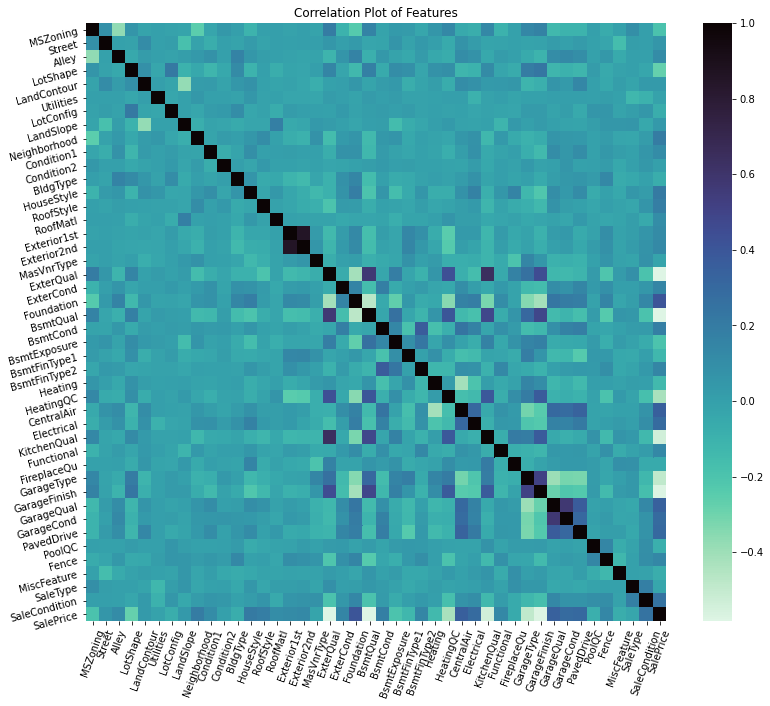

In [37]:
fig=plt.figure(figsize=(13,11))
g1 = sns.heatmap(df_obj_t.corr(),cmap='mako_r')
g1.set_xticklabels(g1.get_xticklabels(),rotation=70,fontsize=10)
g1.set_yticklabels(g1.get_yticklabels(),rotation=15,fontsize=10)
plt.title("Correlation Plot of Features")
plt.show()

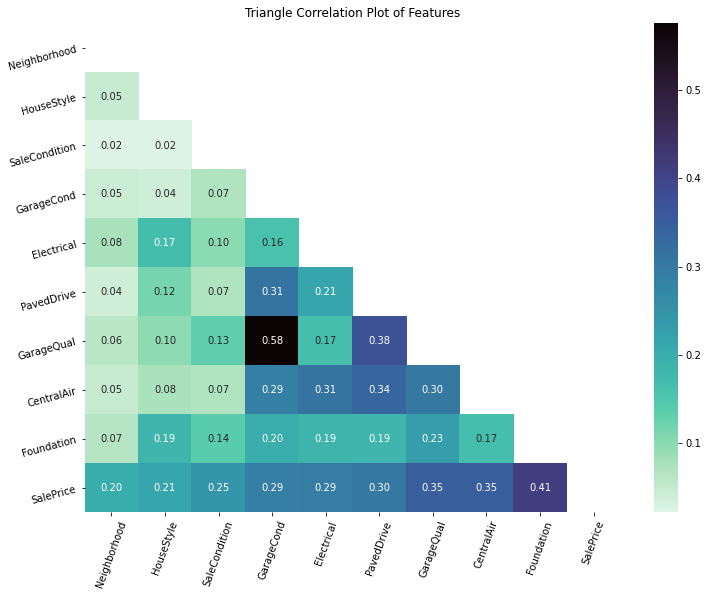

In [38]:
#saleprice correlation matrix

cols_t = df_obj_t.corr().nlargest(10, 'SalePrice')['SalePrice'].index
cols_t = np.array(list(reversed(cols_t)))
cm_t = df_obj_t[cols_t].corr()
mask_t = np.triu(np.ones_like(cm_t, dtype=np.bool))

f, ax = plt.subplots(figsize=(12, 9))
g1 = sns.heatmap(cm_t,cmap='mako_r',fmt='.2f', annot=True, mask=mask_t)
g1.set_xticklabels(g1.get_xticklabels(),rotation=70,fontsize=10)
g1.set_yticklabels(g1.get_yticklabels(),rotation=15,fontsize=10)
plt.title("Triangle Correlation Plot of Features")
plt.show()

Conclusions:
1. Foundation has the highest correlation with SalePrice
2. Rest of categorical features has similarly low correlation

In next steps for the first try all features will be taken into the account.

In [39]:
labelencoder.fit(df['HouseStyle'])
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

{'1.5Fin': 0, '1.5Unf': 1, '1Story': 2, '2.5Fin': 3, '2.5Unf': 4, '2Story': 5, 'SFoyer': 6, 'SLvl': 7}


In [40]:
labelencoder.fit(df['Neighborhood'])
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

{'Blmngtn': 0, 'Blueste': 1, 'BrDale': 2, 'BrkSide': 3, 'ClearCr': 4, 'CollgCr': 5, 'Crawfor': 6, 'Edwards': 7, 'Gilbert': 8, 'IDOTRR': 9, 'MeadowV': 10, 'Mitchel': 11, 'NAmes': 12, 'NPkVill': 13, 'NWAmes': 14, 'NoRidge': 15, 'NridgHt': 16, 'OldTown': 17, 'SWISU': 18, 'Sawyer': 19, 'SawyerW': 20, 'Somerst': 21, 'StoneBr': 22, 'Timber': 23, 'Veenker': 24}


In [41]:
labelencoder.fit(df['SaleCondition'])
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

{'Abnorml': 0, 'AdjLand': 1, 'Alloca': 2, 'Family': 3, 'Normal': 4, 'Partial': 5}


In [42]:
labelencoder.fit(df['RoofStyle'])
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

{'Flat': 0, 'Gable': 1, 'Gambrel': 2, 'Hip': 3, 'Mansard': 4, 'Shed': 5}


In [43]:
labelencoder.fit(df['PavedDrive'])
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

{'N': 0, 'P': 1, 'Y': 2}


In [44]:
labelencoder.fit(df['Electrical'])
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

{'FuseA': 0, 'FuseF': 1, 'FuseP': 2, 'Mix': 3, 'SBrkr': 4}


In [45]:
labelencoder.fit(df['GarageQual'])
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

{'Ex': 0, 'Fa': 1, 'Gd': 2, 'Po': 3, 'TA': 4}


In [46]:
labelencoder.fit(df['CentralAir'])
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

{'N': 0, 'Y': 1}


In [47]:
labelencoder.fit(df['Foundation'])
le_name_mapping = dict(zip(labelencoder.classes_, labelencoder.transform(labelencoder.classes_)))
print(le_name_mapping)

{'BrkTil': 0, 'CBlock': 1, 'PConc': 2, 'Slab': 3, 'Stone': 4, 'Wood': 5}


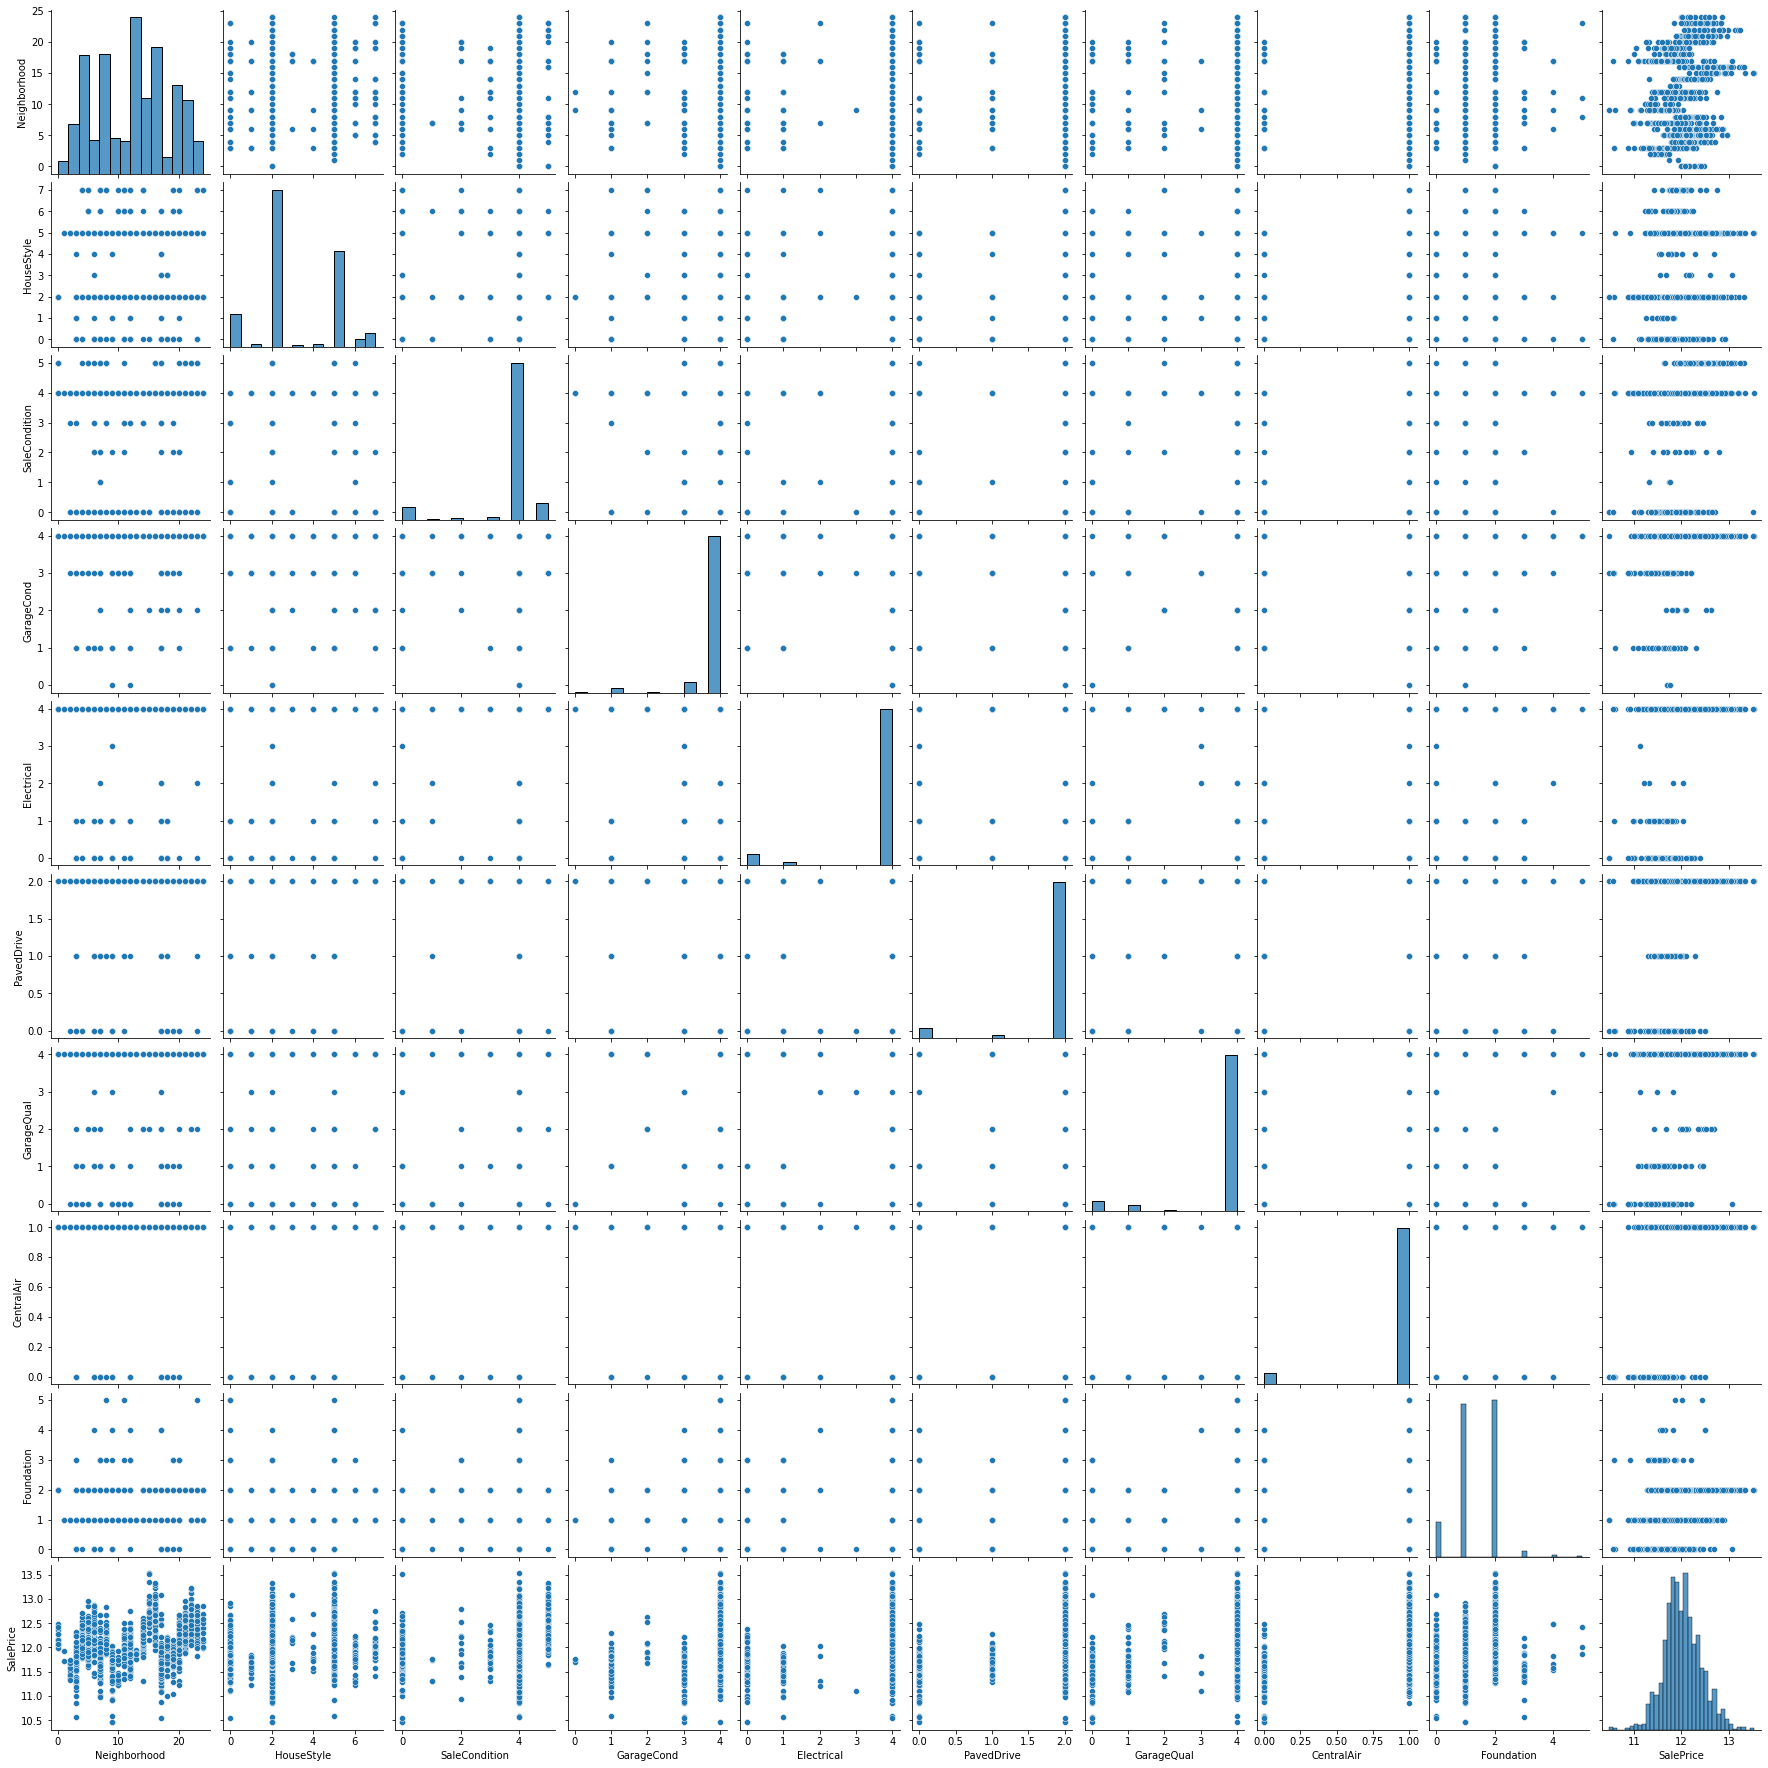

In [48]:
sns.pairplot(df_obj_t[cols_t])
plt.show()

Conclusions:
1. Split Foyer and houses with finished 2nd floor are achieving the highest prices
2. We are able to point out neighborhoods with high prices
3. Normal sales and houses which were unfinished during last assessment have the highest price
4. Gable and Hip roof styles increase the price
5. Paved drive increases the price
6. Standard electricity breakers have the highest popularity
7. Average Garage Quality increases the price
8. Houses with central air are achieving the highest prices
9. Brick and Tile or Poured Contrete foundation types have influence on sale price

In [49]:
cols2 = cols_t[:9]

In [50]:
cols = cols[[0,2,4,6,7,8,9]]

In [51]:
num_data = df.dtypes[train.dtypes != "object"].index
# Check the skew of all numerical features
skewed_data = df[num_data].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_data})
posSkew = skewness[skewness['Skew'] > 0.75]
posSkew

,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694
BsmtHalfBath,3.931594


In [52]:
#Make a list of skewed features
skewed_feat= list(posSkew.index)

In [53]:
for parameter in skewed_feat:
        df[parameter] = np.log1p(df[parameter])

In [54]:
dff = pd.concat([df[cols],df_obj[cols2]], axis=1)

In [55]:
dff.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   YearRemodAdd   2919 non-null   int64  
 1   FullBath       2919 non-null   int64  
 2   TotalBsmtSF    2919 non-null   float64
 3   GarageCars     2919 non-null   float64
 4   GrLivArea      2919 non-null   float64
 5   OverallQual    2919 non-null   int64  
 6   SalePrice      1460 non-null   float64
 7   Neighborhood   2919 non-null   int32  
 8   HouseStyle     2919 non-null   int32  
 9   SaleCondition  2919 non-null   int32  
 10  GarageCond     2919 non-null   int32  
 11  Electrical     2919 non-null   int32  
 12  PavedDrive     2919 non-null   int32  
 13  GarageQual     2919 non-null   int32  
 14  CentralAir     2919 non-null   int32  
 15  Foundation     2919 non-null   int32  
dtypes: float64(4), int32(9), int64(3)
memory usage: 285.1 KB


In [56]:
dff.head()

,YearRemodAdd,FullBath,TotalBsmtSF,GarageCars,GrLivArea,OverallQual,SalePrice,Neighborhood,HouseStyle,SaleCondition,GarageCond,Electrical,PavedDrive,GarageQual,CentralAir,Foundation
0,2003,2,6.753438,2.0,7.444833,7,12.247694,5,5,4,4,4,2,4,1,2
1,1976,2,7.141245,2.0,7.141245,6,12.109011,24,2,4,4,4,2,4,1,1
2,2002,2,6.825460,2.0,7.488294,7,12.317167,5,5,4,4,4,2,4,1,2
3,1970,1,6.629363,3.0,7.448916,7,11.849398,6,5,0,4,4,2,4,1,0
4,2000,2,7.044033,3.0,7.695758,8,12.429216,15,5,4,4,4,2,4,1,2


# Model fitting

### Preparing data for model testing

In [57]:
dff_t = dff[dff.SalePrice.isna()==False]

In [58]:
X_t = dff_t.drop("SalePrice",axis=1)
Y_t = dff_t.SalePrice

In [59]:
sc = StandardScaler()

In [60]:
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(X_t, Y_t, test_size=0.33, random_state=0)

In [61]:
#Standarizing our data
Xt_train = sc.fit_transform(Xt_train)
Xt_test = sc.transform(Xt_test)

### SVR and MSE result

In [59]:
regressor = svm.SVR(kernel='rbf') #Using Support Vector Regression

In [61]:
param = {'C': [0.1, 1, 100, 1000],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        }

grids = GridSearchCV(regressor,param,cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)


grids.fit(Xt_train,Yt_train)
print("Grid search best params: ", grids.best_params_)

Grid search best params:  {'C': 1000, 'epsilon': 0.05, 'gamma': 0.0001}


In [62]:
regr_svr = svm.SVR(kernel='rbf',C=1,epsilon=0.01,gamma=0.005).fit(Xt_train,Yt_train)

In [63]:
Y_pred_svr = regr_svr.predict(Xt_test)

In [64]:
mean_squared_error(Yt_test, Y_pred_svr, squared=False)

0.15391820676281454

### SVR with PCA and MSE result

In [65]:
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [66]:
pca = PCA()
pipe = Pipeline(steps=[('pca', pca), ('regressor', regressor)])
param_grid = {
    'pca__n_components': [2, 3, 5],
    'regressor__C': [0.1, 1, 100, 1000],
    'regressor__epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'regressor__gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
}

In [ ]:
grid_pca = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring = 'neg_mean_squared_error')
grid_pca.fit(Xt_train, Yt_train)
print("Grid search best params: ", grid_pca.best_params_)

KeyboardInterrupt: 

In [ ]:
Y_pred_pca = grid_pca.predict(Xt_test)

In [ ]:
mean_squared_error(Yt_test, Y_pred_pca, squared=False)

PCA is not improving the score which might be cause of the fact that new components are linear combination of the original features.

### Linear Regression and MSE result

In [1]:
from sklearn.linear_model import LinearRegression

In [2]:
linear_regression = LinearRegression()

In [3]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linear_regression,parameters, cv=5, scoring = 'neg_mean_squared_error')
grid_linear = grid_linear.fit(Xt_train,Yt_train)
print("Grid search best params: ", grid_linear.best_params_)

NameError: name 'GridSearchCV' is not defined

In [ ]:
linear_regr = LinearRegression(copy_X=True,fit_intercept=True,normalize=True).fit(Xt_train,Yt_train)

In [ ]:
Y_pred_linear = linear_regr.predict(Xt_test)

In [ ]:
mean_squared_error(Yt_test, Y_pred_linear, squared=False)

### Random Forest Regressor and MSE result

In [67]:
from sklearn.ensemble import RandomForestRegressor

In [68]:
random_forest = RandomForestRegressor()

In [ ]:
param = {'C': [0.1, 1, 100, 1000],
        'epsilon': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        'gamma': [0.0001, 0.001, 0.005, 0.1, 1, 3, 5]
        }

grids = GridSearchCV(regressor,param,cv=5, scoring = 'neg_mean_squared_error', n_jobs=-1)


grids.fit(Xt_train,Yt_train)
print("Grid search best params: ", grids.best_params_)

In [ ]:
forest = RandomForestRegressor(bootstrap=True,max_features='sqrt',n_estimators=100).fit(Xt_train,Yt_train)

In [ ]:
Y_pred_forest = forest.predict(Xt_test)

In [ ]:
mean_squared_error(Yt_test, Y_pred_forest, squared=False)

# Choosing model with the lowest MSE

In [69]:
dff_train = dff[dff.SalePrice.isna()==False]
dff_test = dff[dff.SalePrice.isna()==True]

In [70]:
X_train = dff_train.drop("SalePrice",axis=1)
Y_train = dff_train.SalePrice

X_test = dff_test.drop("SalePrice",axis=1)

In [71]:
#Standarizing the data
X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

In [73]:
para_grids = {
            "n_estimators" : [10,50,100],
            "max_features" : ["auto", "log2", "sqrt"],
            "bootstrap"    : [True, False]
        }


grid_forest_final = GridSearchCV(random_forest, para_grids,cv=5, scoring = 'neg_mean_squared_error')
grid_forest_final.fit(Xt_train, Yt_train)
print("Grid search best params: ", grid_forest_final.best_params_)

Grid search best params:  {'bootstrap': True, 'max_features': 'sqrt', 'n_estimators': 100}


In [74]:
Y_predicted=grid_forest_final.predict(X_test)

In [75]:
Y_predicted = np.exp(Y_predicted)

In [76]:
my_submission = pd.DataFrame({'Id': test.Id, 'SalePrice': Y_predicted})
my_submission

,Id,SalePrice
0,1461,120503.505419
1,1462,144573.530637
2,1463,174039.919966
3,1464,181676.523980
4,1465,203856.188228
...,...,...
1454,2915,84751.666505
1455,2916,87428.494302
1456,2917,135574.921708
1457,2918,102310.222517


In [77]:
my_submission.to_csv('submission.csv', index=False)